# **Machine Learning Project - Basic Part:** Chronic Heart Disease (CHD) prediction.
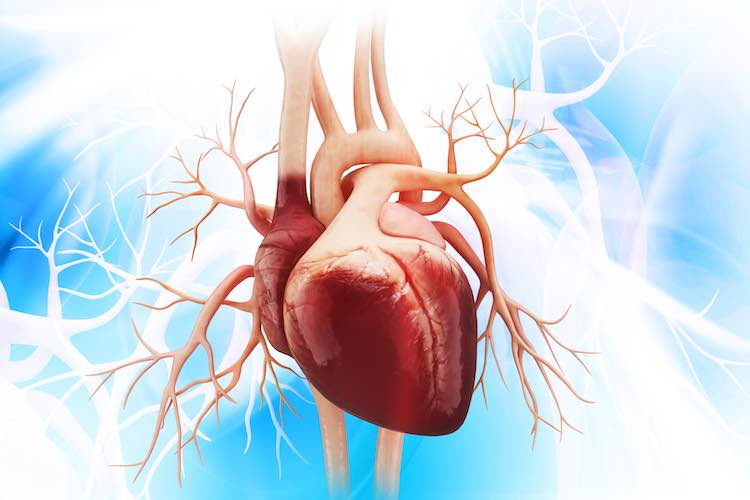

The aim of this project is to apply Machine Learning approaches for classifying whether a person is suffering from Chronic Heart Disease (CHD) or not, using [Cleveland Heart Disease dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UCI Repository. Different Machine Learning methods will be then compared in terms of accuracy score and Ensamble approaches will be applied to improve the final performances. 

### 1. Import file and generate the dataframe

In [152]:
from matplotlib import pyplot
from pandas import set_option
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import VotingClassifier

In [113]:
def mean_acc(model_index,tt_acc,cv_acc):
  mean_model=(tt_acc[model_index]+cv_acc[model_index])/2
  return mean_model

In [2]:
from google.colab import files
uploaded = files.upload()

Saving processed.cleveland.data to processed.cleveland.data


In [4]:
import pandas as pd
filename='processed.cleveland.data'
df = pd.read_csv(filename)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


The *target* field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Since the aim of the project is to simply distinguish presence (values 1,2,3,4) from absence (value 0), I proceed with the following mapping:

In [5]:
df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### 2. Exploratory data analysis

#### Dataset description

The dataset consists in 303 instances and 14 attributes, including the *target* attribute, referrring to the final output of the prediction.

In [6]:
df.shape

(303, 14)

In [7]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
target        int64
dtype: object

In [8]:
set_option('display.width', 200)
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
set_option('precision', 3) 

The attributes can be divided in:

*   numerical values: age, resting blood pressure (*trestbps*), serum cholestoral (*chol*), maximum heart rate achieved (*thalach*), ST depression induced by exercise relative to rest (*oldpeak*);
*   categorical values: sex, chest pain type (*cp*), fasting blood sugar (*fbs*), resting electrocardiographic results (*restecg*), exercise induced angina (*exang*), slope of the peak exercise ST segment (*slope*), the slope of the peak exercise ST segment, number of major vessels (0-3) colored by flourosopy (*ca*), the heart status as retrieved from Thallium test (*thal*). 


In [9]:
names=['age','sex','cp','trestbps', 'chol',	'fbs',	'restecg',	'thalach',	'exang',	'oldpeak',	'slope',	'ca',	'thal',	'target']
cat_att=['sex','cp','fbs','restecg','exang','slope','ca','thal']
num_att=[]
for i in range(len(names)):
  if names[i] not in cat_att:
    num_att.append(names[i])
num_att.remove('target')

#number of numerical attributes
print(len(num_att))

#number of categorical attributes
print(len(cat_att))

5
8


There are 5 numerical attributes and 8 catagorical attributes. 

In [10]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,303.000,303.000,303.000,303.00,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.439,0.680,3.158,131.69,246.693,0.149,0.990,149.607,0.327,1.040,1.601,0.459
std,9.039,0.467,0.960,17.60,51.777,0.356,0.995,22.875,0.470,1.161,0.616,0.499
min,29.000,0.000,1.000,94.00,126.000,0.000,0.000,71.000,0.000,0.000,1.000,0.000
25%,48.000,0.000,3.000,120.00,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000
50%,56.000,1.000,3.000,130.00,241.000,0.000,1.000,153.000,0.000,0.800,2.000,0.000
75%,61.000,1.000,4.000,140.00,275.000,0.000,2.000,166.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.00,564.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


In [11]:
df.target.value_counts()

0    164
1    139
Name: target, dtype: int64

CHD is diagnosed to a total of 139 individuals while 164 individuals are safe.





#### Check for missing values

In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

There are no missing values in the dataset.

#### Bivariate analysis

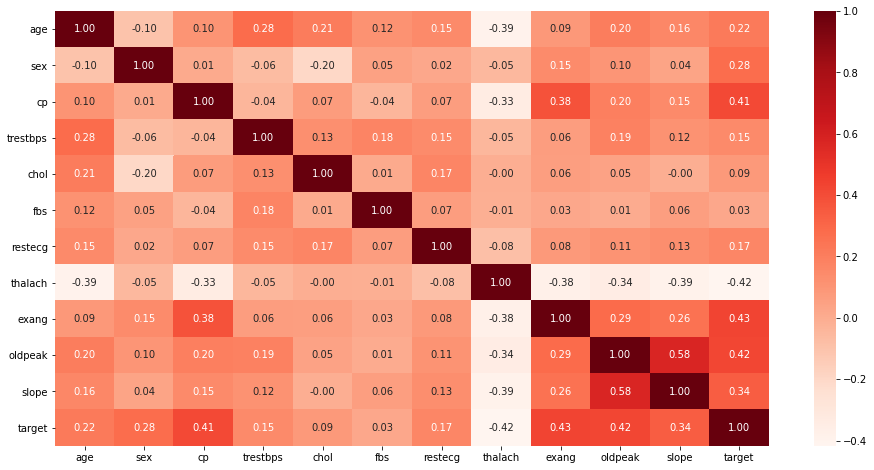

In [13]:
corr =df.corr()
fig, ax =pyplot.subplots(figsize =(16,8))
ax  = sns.heatmap(corr,annot =True,fmt = ".2f", cmap = 'Reds');

In [14]:
corr['target'].sort_values(ascending=False)

target      1.000
exang       0.432
oldpeak     0.425
cp          0.414
slope       0.339
sex         0.277
age         0.223
restecg     0.169
trestbps    0.151
chol        0.085
fbs         0.025
thalach    -0.417
Name: target, dtype: float64

Although there are no attributes with strong positive or negative correlation with the target, chest pain type (cp), exercise induced angina (exang) and peak exercise ST segment (oldpeak) show middle positive correlation, while maximum heart rate achieved (thalach) shows middle negative correlation. Furthermore, slope and oldpeak attributes show a positive correlation of 0.58. A more detailed explanation will be provided in the following paragraph. 

#### Univariate analysis of numerical and categorical attributes

* **age**: the age of the individual expressed in years.



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


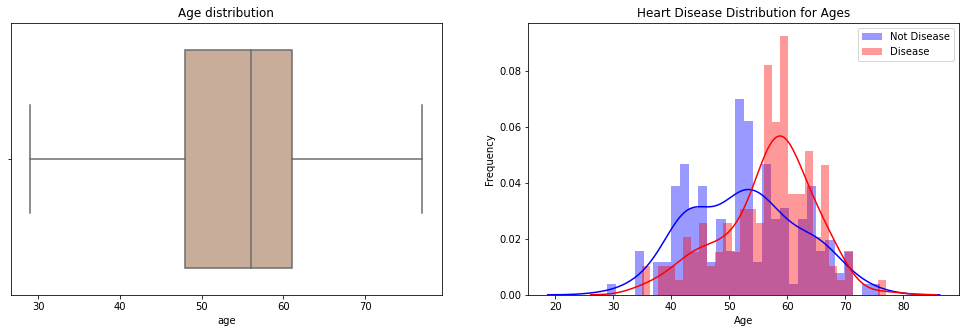

In [15]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['age'], palette = "pink", ax=ax[0])
ax[0].set_title("Age distribution")
sns.distplot(df.age[df['target'] == 0], bins=30, color='blue', label='Not Disease',ax=ax[1])
sns.distplot(df.age[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

* **trestbps**: resting blood bressure in mm Hg on admission to the hospital.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


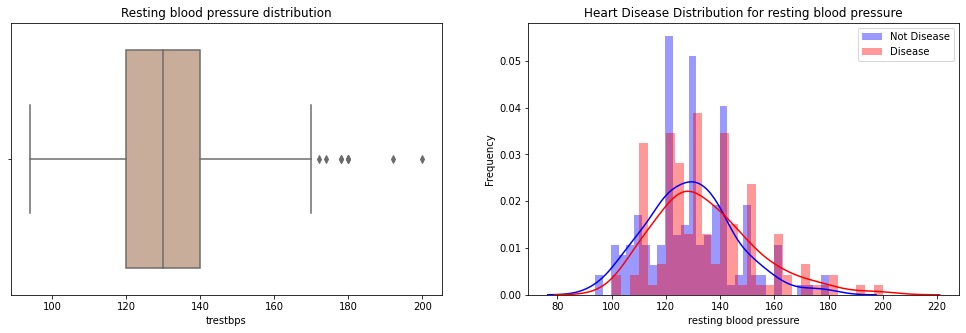

In [16]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['trestbps'], palette = "pink", ax=ax[0])
ax[0].set_title("Resting blood pressure distribution")
sns.distplot(df.trestbps[df['target'] == 0], bins=30, color='blue', label='Not Disease', ax=ax[1])
sns.distplot(df.trestbps[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for resting blood pressure')
plt.xlabel('resting blood pressure')
plt.ylabel('Frequency')
plt.show()

* **chol**: Serum cholesterol in mg/dl



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


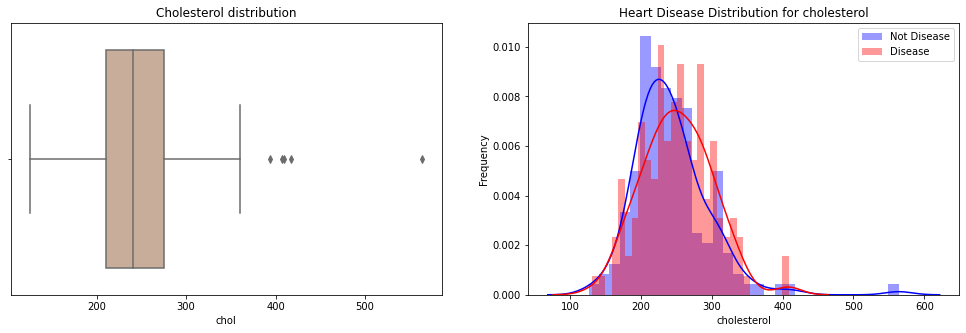

In [17]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['chol'], palette = "pink", ax=ax[0])
ax[0].set_title("Cholesterol distribution")
sns.distplot(df.chol[df['target'] == 0], bins=30, color='blue', label='Not Disease',ax=ax[1])
sns.distplot(df.chol[df['target'] == 1], bins=30, color='red', label='Disease',ax=ax[1])
plt.legend()
plt.title('Heart Disease Distribution for cholesterol')
plt.xlabel('cholesterol')
plt.ylabel('Frequency')
plt.show()

* **oldpeak**: ST depression induced by exercise relative to rest. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline.



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


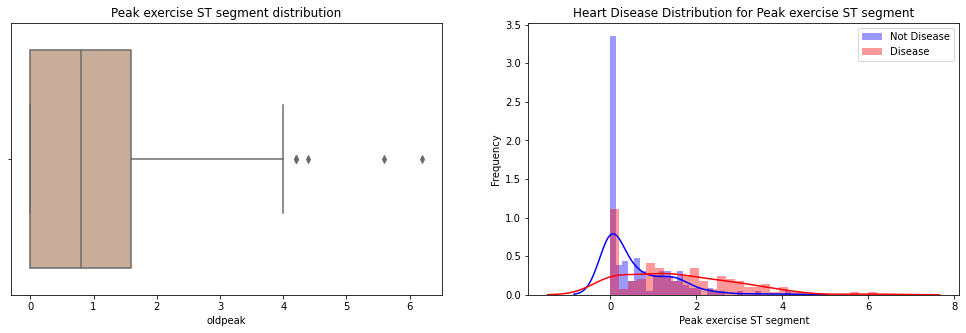

In [18]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['oldpeak'], palette = "pink", ax=ax[0])
ax[0].set_title("Peak exercise ST segment distribution")
sns.distplot(df.oldpeak[df['target'] == 0], bins=30, color='blue', label='Not Disease')
sns.distplot(df.oldpeak[df['target'] == 1], bins=30, color='red', label='Disease')
plt.legend()
plt.title('Heart Disease Distribution for Peak exercise ST segment')
plt.xlabel('Peak exercise ST segment')
plt.ylabel('Frequency')
plt.show()

* **thalach**: maximum heart rate achieved by an individual.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


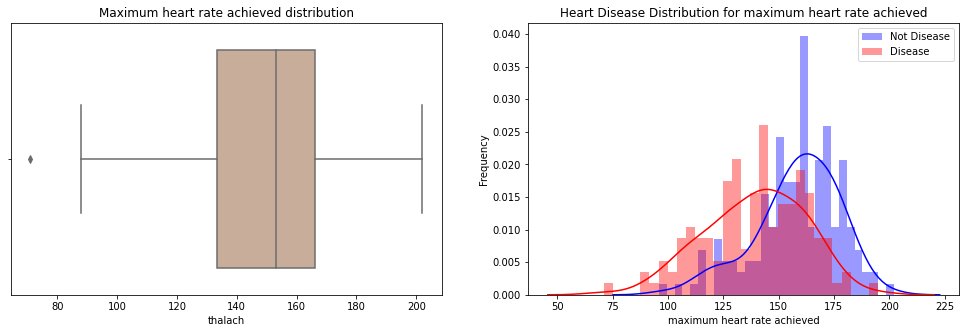

In [19]:
fig,ax=plt.subplots(1,2,figsize=(17,5))
sns.boxplot(x=df['thalach'], palette = "pink", ax=ax[0])
ax[0].set_title("Maximum heart rate achieved distribution")
sns.distplot(df.thalach[df['target'] == 0], bins=30, color='blue', label='Not Disease')
sns.distplot(df.thalach[df['target'] == 1], bins=30, color='red', label='Disease')
plt.legend()
plt.title('Heart Disease Distribution for maximum heart rate achieved')
plt.xlabel('maximum heart rate achieved')
plt.ylabel('Frequency')
plt.show()

**Categorical variables**:


1.  **sex**: 0 female, 1 male. Level wise comparison for target feature shows men are more likely to have a heart disease than women.

2. **cp**: Chest pain type (Categorical with 4 levels-Type 1, Type 2, Type 3 and Type 4) Type 1:typical angina Type 2:atypical angina Type 3:non-anginal pain Type 4:asymptomatic. The most of the safe people have had a non-anginal pain while patients usffering from CHD have had Type 4 cheast pain.

3. **fbs**: Fasting blood sugar > 120 mg/dl (Categorical with 2 levels-1,0). The barplot for fbs below suggest that the fasting blood sugar level may not be a deciding factor for having a heart disease or not.

4. **restecg**: Resting electrocardiographic results (Categorical with 3 levels-0(Normal), 1( having ST-T wave abnormality), 2(showing probable or definite left ventricular hypertrophy)).Healthy people showed normal ECG results while patients with a heart disease showed a ECG result of level 2

5. **exang**: Exercise induced angina (Categorical with 2 levels-1, 0). Having a exercise induced angina for a patient with a heart disease is more dangerous than a patient without a heart disease.This shows having a exercise induced angina may be a deciding factor for having a heart disease.

6. **slope**: The slope of the peak exercise ST segment (categorical with 3 levels- 0 (Upsloping), 1 (flatsloping), 2 (downsloping). 

7. **ca**: Number of major vessels (0-3) colored by flourosopy (Categorical with 4 levels-0, 1, 2, 3)

8. **thal**: The heart status as retrieved from Thallium test (Categorical with 3 levels-3 normal; 6 fixed defect; 7 reversable defect). Healthy people mostly showed a normal heart status while sick people showed mostly a reversible defect condition.



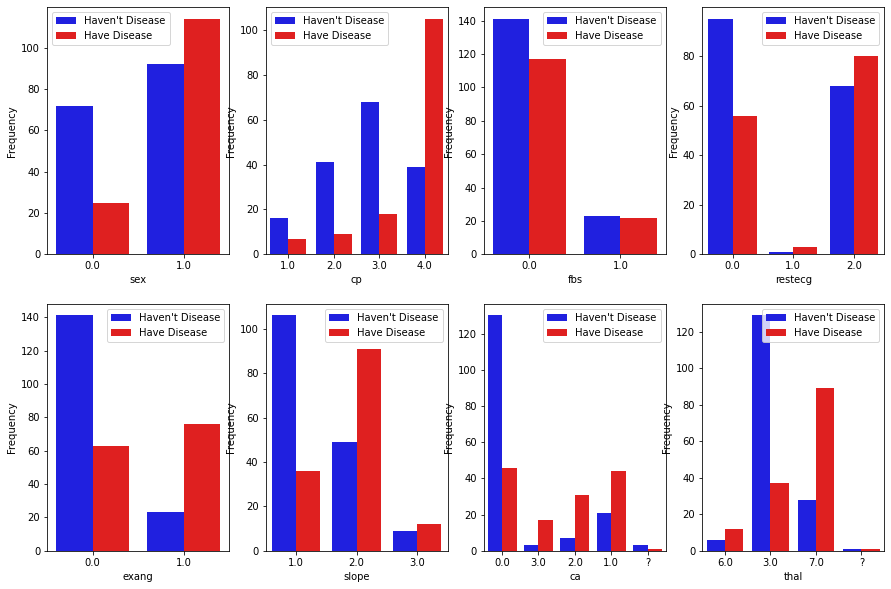

In [20]:
fig, axes = plt.subplots(2,4, figsize=(15,10))
for i, axi in enumerate(axes.flat):
    sns.countplot(x=cat_att[i], hue='target', data=df, palette=['blue','red'] , ax=axi) 
    axi.set(ylabel='Frequency')
    axi.legend(["Haven't Disease", "Have Disease"])

### 3. Data processing and data preparation

In [21]:
dataset = pd.get_dummies(df, columns = cat_att)
dataset.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_0.0,fbs_1.0,restecg_0.0,restecg_1.0,restecg_2.0,exang_0.0,exang_1.0,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_?,thal_3.0,thal_6.0,thal_7.0,thal_?
0,63.0,145.0,233.0,150.0,2.3,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0
1,67.0,160.0,286.0,108.0,1.5,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
2,67.0,120.0,229.0,129.0,2.6,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,37.0,130.0,250.0,187.0,3.5,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0
4,41.0,130.0,204.0,172.0,1.4,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0


In [22]:
from sklearn.preprocessing import StandardScaler
s_sc = StandardScaler()
dataset[num_att] = s_sc.fit_transform(dataset[num_att])
dataset.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_0.0,fbs_1.0,restecg_0.0,restecg_1.0,restecg_2.0,exang_0.0,exang_1.0,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_?,thal_3.0,thal_6.0,thal_7.0,thal_?
0,0.949,0.758,-0.265,0.017,1.087,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0
1,1.392,1.611,0.760,-1.822,0.397,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
2,1.392,-0.665,-0.342,-0.902,1.346,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
3,-1.933,-0.096,0.064,1.637,2.123,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0
4,-1.489,-0.096,-0.826,0.981,0.311,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0


### 4. **Machine Learning model:** Logistic Regression

#### 4.1. Logistic Regression with train-test split

In [41]:
from sklearn.model_selection import train_test_split  
X = dataset.drop('target', axis=1)
Y = dataset.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**Training and testing**

In [42]:
  modelLR = LogisticRegression()
  modelLR.fit(X_train, Y_train)
  LR_acc = modelLR.score(X_test, Y_test)
  LR_acc = LR_acc*100.0
  predictedLR = modelLR.predict(X_test)


**Statistics:** Classification Report

In [43]:
  reportLR = classification_report(Y_test, predictedLR)   
  print(reportLR)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        51
           1       0.82      0.86      0.84        49

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



**Statistics:** Confusion Matrix

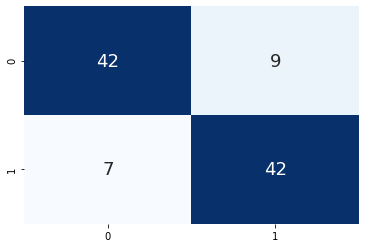

In [44]:
matrix1 = confusion_matrix(Y_test, predictedLR)
sns.heatmap(matrix1,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

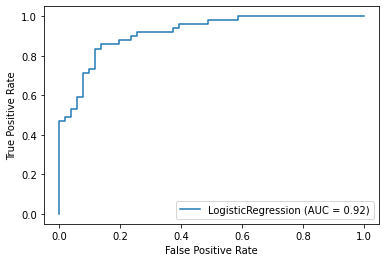

In [45]:
from sklearn import metrics
metrics.plot_roc_curve(modelLR, X_test, Y_test) 

**Training and Testing with different values of seeds**

In [46]:
acc = []  
for seed in range(1,10): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    model = LogisticRegression(solver='lbfgs', max_iter=500)            
    model.fit(X_train, Y_train)            
    result = model.score(X_test, Y_test) 
    output_result = result*100.0
    print("Seed %2d - Accuracy: %.3f%%" % (seed,output_result))   
    acc.append(output_result)

Seed  1 - Accuracy: 89.000%
Seed  2 - Accuracy: 87.000%
Seed  3 - Accuracy: 84.000%
Seed  4 - Accuracy: 88.000%
Seed  5 - Accuracy: 89.000%
Seed  6 - Accuracy: 85.000%
Seed  7 - Accuracy: 83.000%
Seed  8 - Accuracy: 83.000%
Seed  9 - Accuracy: 85.000%


Using different values of random states results in accuracies in the range 83-89%. 

#### 4.2. Logistic Regression with *k*-fold cross-validation

**Training and Testing**

In [47]:
cvfoldLR=KFold(n_splits=70, random_state=7, shuffle=True)
cv_predLR = cross_val_predict(LogisticRegression(), X, Y, cv=cvfoldLR)

**Statistics**: accuracy, recall and precision

In [48]:
cv_accLR = accuracy_score(Y, cv_predLR)  
cv_recLR=recall_score(Y,cv_predLR) 
cv_precLR = precision_score(Y, cv_predLR) 
print("Accuracy: "+str(cv_accLR*100)+" %")
print("Recall: "+str(cv_recLR*100)+" %")
print("Precision: "+str(cv_precLR*100)+" %")

Accuracy: 84.81848184818482 %
Recall: 79.85611510791367 %
Precision: 86.04651162790698 %


**Statistics:** Confusion Matrix

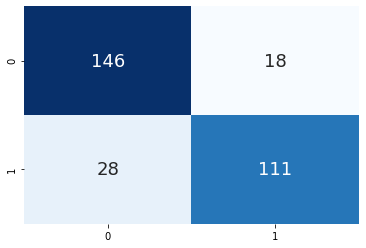

In [49]:
matrix2 = confusion_matrix(Y, cv_predLR)
sns.heatmap(matrix2,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

**Training and Testing with different number of folds**

In [50]:
num_folds = [5,7,10,20,40,50,80,100,120]
seed = 7
for i in num_folds:
  kfold = KFold(n_splits=i, random_state=seed, shuffle=True)
  modelLRkF = LogisticRegression()
  resultsLRkF = cross_val_score(modelLRkF, X, Y, cv=kfold)
  #print("Seed %2d - Accuracy: %.3f%%" % (i,results.mean()*100.0, results.std()*100.0))
  print("Number of folds: "+ str(i)+" Accuracy: %.3f%% (%.3f%%)" % (resultsLRkF.mean()*100.0, resultsLRkF.std()*100.0))

Number of folds: 5 Accuracy: 83.475% (7.692%)
Number of folds: 7 Accuracy: 84.499% (6.136%)
Number of folds: 10 Accuracy: 84.839% (6.628%)
Number of folds: 20 Accuracy: 84.521% (9.331%)
Number of folds: 40 Accuracy: 84.777% (13.780%)
Number of folds: 50 Accuracy: 84.857% (14.644%)
Number of folds: 80 Accuracy: 85.104% (20.013%)
Number of folds: 100 Accuracy: 85.500% (19.812%)
Number of folds: 120 Accuracy: 84.861% (22.464%)


Changing the number of folds does not affect significantlly the final accuracy of model's predictions. However, standard deviation changes in a range between 6% and 22%.

#### 4.3. Final Results

In [51]:
results_df = pd.DataFrame(data=[["Logistic Regression", LR_acc, cv_accLR*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %'])
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818


### 5. **Machine Learning model:** K-Neighbors

#### 5.1. K-Neighbors with train-test split

**Training and Testing**

In [52]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)
knn_pred = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test, knn_pred)


**Statistics**: Classification Report

In [53]:
knn_report = classification_report(Y_test, knn_pred)   
print(knn_report)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        53
           1       0.75      0.77      0.76        47

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



**Statistics:** Confusion Matrix

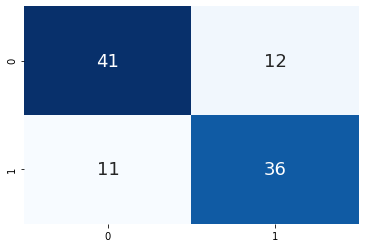

In [54]:
matrix4 = confusion_matrix(Y_test, knn_pred)
sns.heatmap(matrix4,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

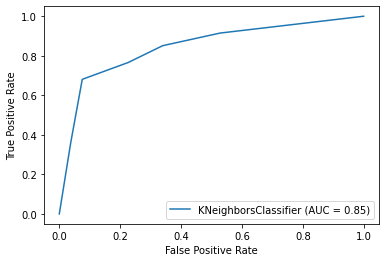

In [55]:
metrics.plot_roc_curve(knn_clf, X_test, Y_test)

Even if model accuracy is high (77%), it is lower than accuracy reached by Logistic Regression model. Furthermore, the number of uncorrect prediction (23) as well as the AUC (0.85) reflect the fact that, until now, Logistic Regression outperforms k-nearest neighours model.

**Training and Testing with different values of seeds**

In [56]:
acc = []  
for seed in range(1,10): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    model =  KNeighborsClassifier()          
    model.fit(X_train, Y_train)            
    result = model.score(X_test, Y_test) 
    output_result = result*100.0
    print("Seed %2d - Accuracy: %.3f%%" % (seed,output_result))   
    acc.append(output_result)

Seed  1 - Accuracy: 85.000%
Seed  2 - Accuracy: 85.000%
Seed  3 - Accuracy: 88.000%
Seed  4 - Accuracy: 87.000%
Seed  5 - Accuracy: 79.000%
Seed  6 - Accuracy: 82.000%
Seed  7 - Accuracy: 83.000%
Seed  8 - Accuracy: 76.000%
Seed  9 - Accuracy: 77.000%


#### 5.2. K-Neighbors with *k*-fold cross-validation

**Training and Testing**

In [57]:
cvfoldknn=KFold(n_splits=70, random_state=7, shuffle=True)
cv_predknn = cross_val_predict(KNeighborsClassifier(), X, Y, cv=cvfoldknn)

**Statistics**: accuracy, recall and precision

In [58]:
cv_accknn = accuracy_score(Y, cv_predknn)   
cv_recknn = recall_score(Y, cv_predknn) 
cv_precknn = precision_score(Y, cv_predknn)
print("Accuracy: "+str(cv_accknn*100)+" %")
print("Recall: "+str(cv_recknn*100)+" %")
print("Precision: "+str(cv_precknn*100)+" %")

Accuracy: 81.51815181518151 %
Recall: 77.6978417266187 %
Precision: 81.203007518797 %


**Statistics:** Confusion Matrix

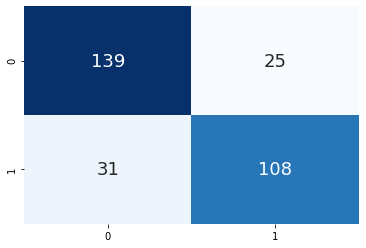

In [59]:
matrix5 = confusion_matrix(Y, cv_predknn)
sns.heatmap(matrix5,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

In [60]:
num_folds = [5,7,10,20,40,50,80,100,120]
seed = 7
for i in num_folds:
  kfoldknn=KFold(n_splits=i, random_state=seed, shuffle=True)
  modelknn_kF = KNeighborsClassifier()
  resultsknn_kF = cross_val_score(modelknn_kF, X, Y, cv=kfoldknn)
  print("Number of folds: "+ str(i)+" Accuracy: %.3f%% (%.3f%%)" % (resultsknn_kF.mean()*100.0, resultsknn_kF.std()*100.0))

Number of folds: 5 Accuracy: 80.842% (4.583%)
Number of folds: 7 Accuracy: 81.516% (5.271%)
Number of folds: 10 Accuracy: 81.527% (6.466%)
Number of folds: 20 Accuracy: 81.542% (7.683%)
Number of folds: 40 Accuracy: 81.786% (12.033%)
Number of folds: 50 Accuracy: 81.524% (13.937%)
Number of folds: 80 Accuracy: 81.354% (18.552%)
Number of folds: 100 Accuracy: 81.583% (21.418%)
Number of folds: 120 Accuracy: 81.111% (24.050%)


Also in this case, changing the number of folds does not affect significantlly the final accuracy and the standard deviation behaves as in Logistic Regression. 

#### 5.3. Final Results

In [61]:
results_df1 = pd.DataFrame(data=[["K-Neighbours", knn_acc*100, cv_accknn*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %'])
results_df = results_df.append(results_df1, ignore_index=True)
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818
1,K-Neighbours,77.0,81.518


### 6. **Machine Learning model**: SVM

#### 6.1. SVM with train-test split

**Training and Testing**

In [62]:
modelSVM = SVC(kernel = 'rbf')
modelSVM.fit(X_train, Y_train)
SVM_pred = modelSVM.predict(X_test)

**Statistics:** Classification Report

In [63]:
SVM_report = classification_report(Y_test, SVM_pred)
SVM_acc = accuracy_score(Y_test, SVM_pred)
 print(SVM_report)

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        53
           1       0.77      0.85      0.81        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



**Statistics:** Confusion Matrix

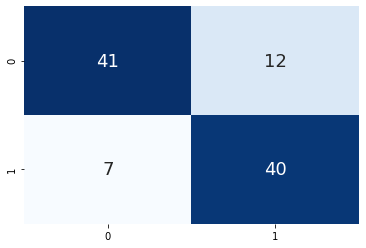

In [64]:
matrix6 = confusion_matrix(Y_test, SVM_pred)
sns.heatmap(matrix6,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

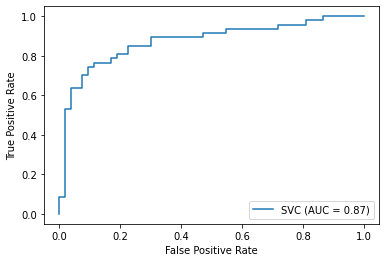

In [65]:
metrics.plot_roc_curve(modelSVM, X_test, Y_test)

**Training and Testing with different value of seeds**

In [66]:
acc = []  
for seed in range(1,10): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    model =  SVC(kernel = 'rbf')          
    model.fit(X_train, Y_train)            
    result = model.score(X_test, Y_test) 
    output_result = result*100.0
    print("Seed %2d - Accuracy: %.3f%%" % (seed,output_result))   
    acc.append(output_result)

Seed  1 - Accuracy: 85.000%
Seed  2 - Accuracy: 88.000%
Seed  3 - Accuracy: 88.000%
Seed  4 - Accuracy: 84.000%
Seed  5 - Accuracy: 88.000%
Seed  6 - Accuracy: 84.000%
Seed  7 - Accuracy: 79.000%
Seed  8 - Accuracy: 82.000%
Seed  9 - Accuracy: 81.000%


#### 6.2. SVM with *k*-fold cross-validation

**Training and Testing**

In [68]:
cvfoldSVM=KFold(n_splits=70, random_state=7, shuffle=True)
cv_predSVM = cross_val_predict(modelSVM, X, Y, cv=cvfoldSVM) 

**Statistics:** accuracy, recall and precision

In [69]:
cv_accSVM = accuracy_score(Y, cv_predSVM)
cv_recSVM = recall_score(Y, cv_predSVM)
cv_precSVM = precision_score(Y, cv_predSVM)
print("Accuracy: "+str(cv_accSVM*100)+" %")
print("Recall: "+str(cv_recSVM*100)+" %")
print("Precision: "+str(cv_precSVM*100)+" %") 

Accuracy: 84.15841584158416 %
Recall: 81.29496402877699 %
Precision: 83.7037037037037 %


**Statistics:** Confusion Matrix

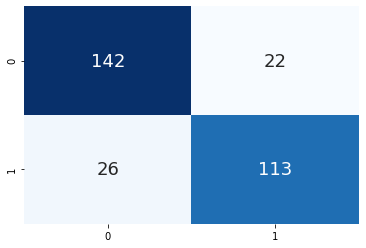

In [70]:
matrix7 = confusion_matrix(Y, cv_predSVM)
sns.heatmap(matrix7,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

**Training and Testing with different number of folds**

In [71]:
num_folds = [5,7,10,20,40,50,80,100,120]
seed = 7
for i in num_folds:
  kfoldSVM=KFold(n_splits=i, random_state=seed, shuffle=True)
  modelSVM_kF = SVC(kernel = 'rbf')
  resultsSVM_kF = cross_val_score(modelSVM_kF, X, Y, cv=kfoldSVM)
  print("Number of folds: "+ str(i)+" Accuracy: %.3f%% (%.3f%%)" % (resultsSVM_kF.mean()*100.0, resultsSVM_kF.std()*100.0))

Number of folds: 5 Accuracy: 81.809% (6.650%)
Number of folds: 7 Accuracy: 84.144% (7.910%)
Number of folds: 10 Accuracy: 83.151% (6.565%)
Number of folds: 20 Accuracy: 84.125% (7.766%)
Number of folds: 40 Accuracy: 83.929% (14.202%)
Number of folds: 50 Accuracy: 84.143% (14.797%)
Number of folds: 80 Accuracy: 83.542% (19.138%)
Number of folds: 100 Accuracy: 84.500% (20.447%)
Number of folds: 120 Accuracy: 83.750% (22.716%)


#### 6.3. Final Results

In [72]:
results_df2 = pd.DataFrame(data=[["SVM", SVM_acc*100, cv_accSVM*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %'])
results_df = results_df.append(results_df2, ignore_index=True)
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818
1,K-Neighbours,77.0,81.518
2,SVM,81.0,84.158


### 7. **Machine Learning model:** Naive Bayes

#### 7.1. Naive Bayes with train-test split

**Training and Testing**

In [73]:
modelGNB = GaussianNB()
modelGNB.fit(X_train, Y_train)
GNB_pred = modelGNB.predict(X_test)

**Statistics:** Classification Report

In [74]:
GNB_report = classification_report(Y_test, GNB_pred) 
GNB_acc = accuracy_score(Y_test, GNB_pred)  
print(GNB_report)

              precision    recall  f1-score   support

           0       0.85      0.53      0.65        53
           1       0.63      0.89      0.74        47

    accuracy                           0.70       100
   macro avg       0.74      0.71      0.69       100
weighted avg       0.74      0.70      0.69       100



**Statistics:** Confusion Matrix

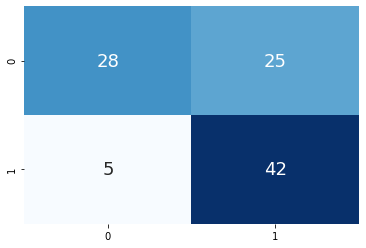

In [75]:
matrix8 = confusion_matrix(Y_test, GNB_pred)
sns.heatmap(matrix8,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

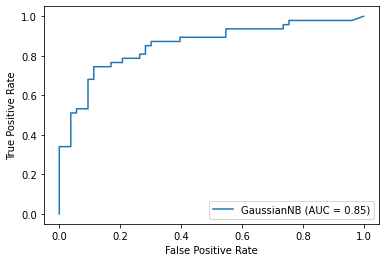

In [76]:
metrics.plot_roc_curve(modelGNB, X_test, Y_test)

**Training and Testing with different value for seeds**

In [77]:
acc = []  
for seed in range(1,10): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    model = GaussianNB()           
    model.fit(X_train, Y_train)            
    result = model.score(X_test, Y_test) 
    output_result = result*100.0
    print("Seed %2d - Accuracy: %.3f%%" % (seed,output_result))   
    acc.append(output_result)

Seed  1 - Accuracy: 83.000%
Seed  2 - Accuracy: 80.000%
Seed  3 - Accuracy: 70.000%
Seed  4 - Accuracy: 80.000%
Seed  5 - Accuracy: 72.000%
Seed  6 - Accuracy: 81.000%
Seed  7 - Accuracy: 83.000%
Seed  8 - Accuracy: 79.000%
Seed  9 - Accuracy: 70.000%


#### 7.2. Naive Bayes with *k*-fold cross-validation

**Training and Testing**

In [79]:
cvfoldGNB=KFold(n_splits=70, random_state=7, shuffle=True)
cv_predGNB = cross_val_predict(modelGNB, X, Y, cv=cvfoldGNB)   

**Statistics:** accuracy, recall and precision

In [80]:
cv_accGNB = accuracy_score(Y, cv_predGNB)  
cv_recGNB = recall_score(Y, cv_predGNB) 
cv_precGNB = precision_score(Y, cv_predGNB)
print("Accuracy: "+str(cv_accGNB*100)+" %")
print("Recall: "+str(cv_recGNB*100)+" %")
print("Precision: "+str(cv_precGNB*100)+" %")

Accuracy: 82.50825082508251 %
Recall: 78.41726618705036 %
Precision: 82.57575757575758 %


**Statistics:** Confusion Matrix

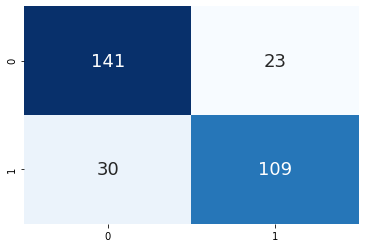

In [81]:
matrix9 = confusion_matrix(Y, cv_predGNB)
sns.heatmap(matrix9,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

**Training and Testing with different numbers of folds**

In [82]:
num_folds = [5,7,10,20,40,50,80,100,120]
seed = 7
for i in num_folds:
  kfoldGNB=KFold(n_splits=i, random_state=seed, shuffle=True)
  modelGNB_kF = GaussianNB()
  resultsGNB_kF = cross_val_score(modelGNB_kF, X, Y, cv=kfoldGNB)
  print("Number of folds: "+ str(i)+" Accuracy: %.3f%% (%.3f%%)" % (resultsGNB_kF.mean()*100.0, resultsGNB_kF.std()*100.0))

Number of folds: 5 Accuracy: 81.158% (7.763%)
Number of folds: 7 Accuracy: 77.514% (7.604%)
Number of folds: 10 Accuracy: 81.828% (8.210%)
Number of folds: 20 Accuracy: 82.812% (8.820%)
Number of folds: 40 Accuracy: 82.455% (14.886%)
Number of folds: 50 Accuracy: 82.476% (17.384%)
Number of folds: 80 Accuracy: 82.604% (21.090%)
Number of folds: 100 Accuracy: 83.500% (22.047%)
Number of folds: 120 Accuracy: 83.194% (24.104%)


#### 7.3. Final Results

In [83]:
results_df3 = pd.DataFrame(data=[["Naive Bayes", GNB_acc*100, cv_accGNB*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %'])
results_df = results_df.append(results_df3, ignore_index=True)
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818
1,K-Neighbours,77.0,81.518
2,SVM,81.0,84.158
3,Naive Bayes,70.0,82.508


### 8. **Machine Learning model:** Decision Tree

#### 8.1. Decision Tree with train-test split

**Training and Testing**

In [84]:
modelDT = DecisionTreeClassifier()
modelDT.fit(X_train, Y_train)
DT_pred = modelDT.predict(X_test)

**Statistics:** Classification Report

In [85]:
DT_report = classification_report(Y_test, DT_pred) 
DT_acc = accuracy_score(Y_test,DT_pred)
print(DT_report)

              precision    recall  f1-score   support

           0       0.80      0.74      0.76        53
           1       0.73      0.79      0.76        47

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



**Statistics:** Confusion Matrix

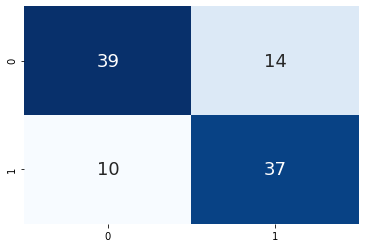

In [86]:
matrix10 = confusion_matrix(Y_test, DT_pred)
sns.heatmap(matrix10,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})  
plt.show()

**Statistics:** ROC curve and AUC

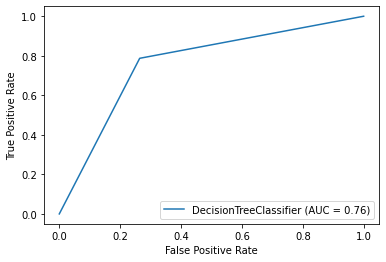

In [87]:
metrics.plot_roc_curve(modelDT, X_test, Y_test)

**Training and Testing with different value of seeds**

In [88]:
acc = []  
for seed in range(1,10): 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
    model = DecisionTreeClassifier()            
    model.fit(X_train, Y_train)            
    result = model.score(X_test, Y_test) 
    output_result = result*100.0
    print("Seed %2d - Accuracy: %.3f%%" % (seed,output_result))   
    acc.append(output_result)

Seed  1 - Accuracy: 80.000%
Seed  2 - Accuracy: 77.000%
Seed  3 - Accuracy: 68.000%
Seed  4 - Accuracy: 76.000%
Seed  5 - Accuracy: 77.000%
Seed  6 - Accuracy: 75.000%
Seed  7 - Accuracy: 76.000%
Seed  8 - Accuracy: 73.000%
Seed  9 - Accuracy: 78.000%


#### 8.2. Decision Tree with *k*-fold cross-validation

**Training and Testing**

In [89]:
cvfoldDT=KFold(n_splits=70, random_state=7, shuffle=True)
cv_predDT = cross_val_predict(DecisionTreeClassifier(), X, Y, cv=cvfoldDT)  

**Statistics:** accuracy, recall and precision

In [90]:
cv_accDT = accuracy_score(Y, cv_predDT)
cv_recDT = recall_score(Y, cv_predDT)
cv_precDT = precision_score(Y, cv_predDT)
print("Accuracy: "+str(cv_accDT*100)+" %")
print("Recall: "+str(cv_recDT*100)+" %")
print("Precision: "+str(cv_precDT*100)+" %")

Accuracy: 74.25742574257426 %
Recall: 72.66187050359713 %
Precision: 71.63120567375887 %


**Statistics:** Confusion Matrix

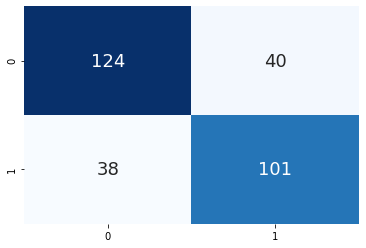

In [91]:
matrix11 = confusion_matrix(Y, cv_predDT)
sns.heatmap(matrix11,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

**Training and Testing with different number od folds**

In [92]:
for i in num_folds:
  kfoldDT=KFold(n_splits=i, random_state=7, shuffle=True)
  modelDT_kF = DecisionTreeClassifier()
  resultsDT_kF = cross_val_score(modelDT_kF, X, Y, cv=kfoldDT)
  print("Number of folds: "+ str(i)+" Accuracy: %.3f%% (%.3f%%)" % (resultsDT_kF.mean()*100.0, resultsDT_kF.std()*100.0))

Number of folds: 5 Accuracy: 73.918% (4.404%)
Number of folds: 7 Accuracy: 75.589% (4.880%)
Number of folds: 10 Accuracy: 74.237% (6.177%)
Number of folds: 20 Accuracy: 76.208% (7.478%)
Number of folds: 40 Accuracy: 76.071% (14.757%)
Number of folds: 50 Accuracy: 74.286% (16.544%)
Number of folds: 80 Accuracy: 74.479% (21.664%)
Number of folds: 100 Accuracy: 76.917% (23.060%)
Number of folds: 120 Accuracy: 75.000% (25.276%)


#### 8.3. Final Results

In [93]:
results_df4 = pd.DataFrame(data=[["Decision Tree", DT_acc*100, cv_accDT*100]], 
                          columns=['Model', 'TT Accuracy %', 'CV Accuracy %'])
results_df = results_df.append(results_df4, ignore_index=True)
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818
1,K-Neighbours,77.0,81.518
2,SVM,81.0,84.158
3,Naive Bayes,70.0,82.508
4,Decision Tree,76.0,74.257


### 9. Models comparison

The table below shows the final accuracies for each Machine Learning algorithm in both train-test split and *k*-fold cross-validation. A visual inspection of such table is provided in the histograms below.

In [94]:
results_df

,Model,TT Accuracy %,CV Accuracy %
0,Logistic Regression,84.0,84.818
1,K-Neighbours,77.0,81.518
2,SVM,81.0,84.158
3,Naive Bayes,70.0,82.508
4,Decision Tree,76.0,74.257


In [99]:
ML_algos = ['Logistic Regression', 'K-nearest neighbours', 'SVM', 'Naive Bayes', 'Decision Trees']

In [ ]:
all_resultsTT=results_df['TT Accuracy %']
all_resultsCV=results_df['CV Accuracy %']

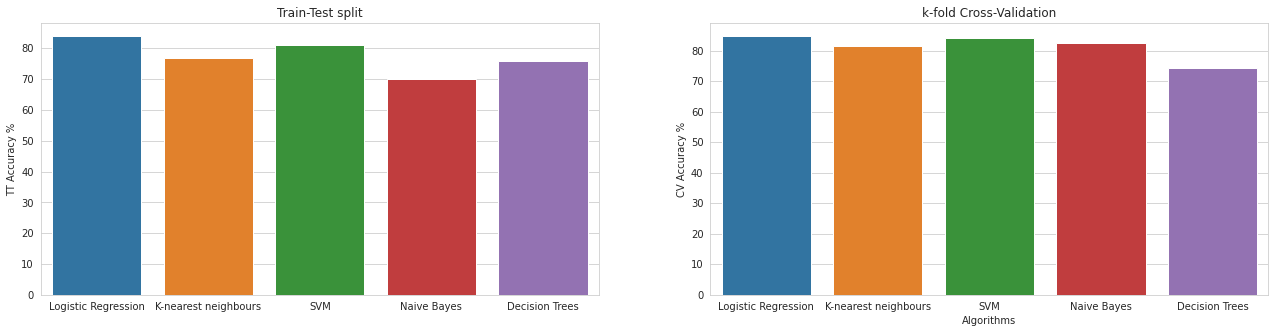

In [111]:
fig,ax=plt.subplots(1,2,figsize=(22,5))
sns.set_style("whitegrid")
sns.barplot(x=ML_algos, y=all_resultsTT, ax=ax[0])
ax[0].set_title("Train-Test split")
plt.yticks()
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
plt.yticks()
ax[1].set_title("k-fold Cross-Validation")
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=ML_algos, y=all_resultsCV, ax=ax[1])
plt.show()

#plt.figure(figsize=(16,5))



The means among the accuracies resulting in train-test split and *k*-fold cross-validation procedures are calculated for each ML algorithm and then plotted:

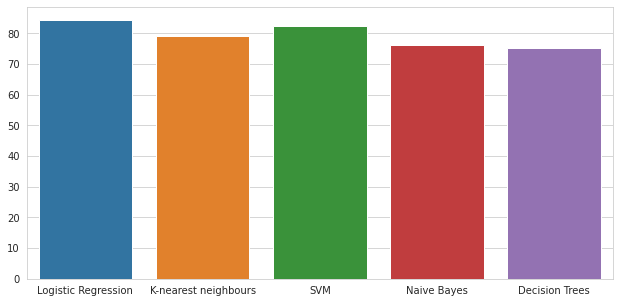

[84.40924092409242, 79.25907590759076, 82.57920792079207, 76.25412541254126, 75.12871287128712]


In [123]:
plt.figure(figsize=(10.5,5))
mean_accuracies=[]
for i in range(len(ML_algos)):
  #print(ML_algos[i]+" "+str(mean_acc(i,all_resultsTT,all_resultsCV)))
  mean_accuracies.append(mean_acc(i,all_resultsTT,all_resultsCV))
ax = sns.barplot(x=ML_algos, y=mean_accuracies)
plt.show()

As a results:

*   for almost all Machine Learning models, *k*-fold cross-validation gives higher performances in terms of accuracy score with respect to train-test split, except for Decision Tree method;
*   the highest mean accuracy is reached by Logistic Regression (84.409 %), which is immediantly followed by Support Vector Machines (82.579 %).



### 10. Ensamble methods

Ensamble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. The most common Ensamble methods that will be employed in the following steps are:


*   **Bagging** involves having each model in the ensemble vote with equal weight;
*   **Boosting** involves incrementally building an ensemble by training each new model instance to emphasize the training instances that previous models mis-classified;
*   **Voting** trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.



#### 10.1. Bagging Classifier

**Bagged Decision Trees**

In [127]:
num_trees = 100
modelBC = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=7, bootstrap = True)
resultsBC = cross_val_score(modelBC, X, Y, cv=kfoldDT)
print("Accuracy: "+str(resultsBC.mean()*100)+ " %")

Accuracy: 80.55555555555554 %


Bagging classifier returns an higher value of accuracy with respect to both train-test split (76.0 %) and *k*-fold cross-validation accuracies (74.257 %). 

**Random Forest Classifier**



In [147]:
num_trees = 100
#max_features = 5
for i in range(2,14):
  modelRFC = RandomForestClassifier(n_estimators=num_trees, max_features=i)
  resultsRFC = cross_val_score(model, X, Y, cv=kfoldDT)
  print("Accuracy: "+str(resultsRFC.mean()*100)+ " %")

Accuracy: 74.16666666666667 %
Accuracy: 75.0 %
Accuracy: 72.22222222222221 %
Accuracy: 72.08333333333333 %
Accuracy: 75.27777777777777 %
Accuracy: 75.13888888888889 %
Accuracy: 74.44444444444446 %
Accuracy: 74.72222222222221 %
Accuracy: 74.44444444444446 %
Accuracy: 74.02777777777779 %
Accuracy: 76.52777777777779 %
Accuracy: 76.52777777777779 %


Random Forest Classifier returns, for different number of maximum features selected, accuracies in the range 72-76.5%, thus not improving significanlty the previous accuracy.

**ExtraTree Classifier**

In [149]:
num_trees = 100
for i in range(2,14):
  modelETC = ExtraTreesClassifier(n_estimators=num_trees, max_features=i)
  resultsETC = cross_val_score(modelETC, X, Y, cv=kfoldDT)
  print("Accuracy: "+str(resultsETC.mean()*100)+" %")

Accuracy: 82.36111111111111 %
Accuracy: 81.94444444444446 %
Accuracy: 81.80555555555557 %
Accuracy: 81.52777777777777 %
Accuracy: 81.94444444444446 %
Accuracy: 80.55555555555554 %
Accuracy: 81.94444444444444 %
Accuracy: 82.6388888888889 %
Accuracy: 82.5 %
Accuracy: 81.11111111111113 %
Accuracy: 81.11111111111111 %
Accuracy: 80.83333333333333 %


Accuracy scores increase w.r.t. both the single DecisionTree Classifier and the two previous Ensable methods. Accuracy is in the range 80.8-82.6 % changing the number of maximum features considered. 

#### 10.2. Boosting Classifier



**Stochastic Gradient Boosting**

In [156]:
seed = 7
num_trees = 100
kfold = KFold(n_splits=70, random_state=seed,shuffle=True)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: "+str(results.mean()*100)+" %")

Accuracy: 79.5 %


Also in this case, Boosting classifier, as Ensamble method, increases the accuracy. 

#### 10.3. Voting Classifier

In [164]:
from sklearn.ensemble import VotingClassifier
estimators = []
model1 = LogisticRegression()
estimators.append(( 'logistic' , model1))
model2 = DecisionTreeClassifier()
estimators.append(( 'DT' , model2))
model3 = SVC()
estimators.append(( 'svm' , model3))
model4 = GaussianNB()
estimators.append(('NB', model4))
model5 = KNeighborsClassifier()
estimators.append(('KNN', model5))

#with train-test split
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, Y_train)
predEN = ensemble.predict(X_test)
accEN = accuracy_score(Y_test, predEN)
print("Accuracy train-test split: "+str(accEN*100)+ " %")

#with k-fold cross-validation
kfold = KFold(n_splits=70, random_state=7, shuffle=True)
ensembleCV = VotingClassifier(estimators)
resultsCV = cross_val_score(ensembleCV, X, Y, cv=kfold)
print("Accuracy k-fold cross-validation: "+ str(resultsCV.mean()*100) + " %")

Accuracy train-test split: 80.0 %
Accuracy k-fold cross-validation: 84.21428571428572 %
